In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from skimage import morphology
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from config import *

In [50]:
class DataLoader:
    shape = (224, 224, 1)
    
    def __init__(self, _path: str) -> None:
        self.data = pd.read_csv(_path)
        self.__index, self._size = 0, self.data.shape[0]
        
        self.images = np.empty((self._size,) + self.shape, dtype='float16')
        self.labels = np.empty(self._size, dtype='uint8')

    def load_data(self) -> None:
        for _, _path, _categories in self.data.values:
            self.add_image(_path, _categories)
    
    def add_image(self, _path: str, category: int) -> None:
        image_path = f"data/train/{CATEGORIES_REVERSE[category]}/{_path}"
        image = ~cv2.imread(image_path, 0)/255
        
        self.images[self.__index] = np.asarray(image, dtype='float16').reshape(self.shape)
        self.labels[self.__index] = category
        self.__index += 1

        print(f"[+] Progress: {self.__index}/{self._size}", end='\r')
        
        if self.__index == self._size:
            self.labels = to_categorical(self.labels)
            print(f"\n[+] DONE")
    
    def show_image(self, index: int) -> None:
        plt.imshow(self.images[index], cmap='gray')

[+] Progress: 14629/14629
[+] DONE


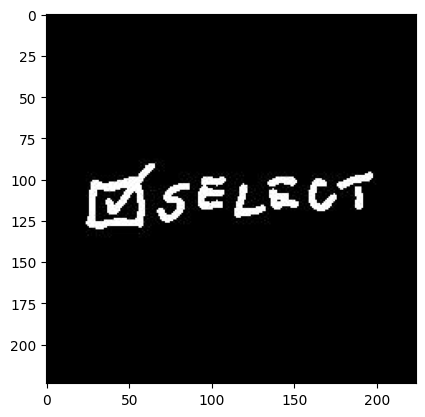

In [51]:
train_data = DataLoader(train_set_path)
train_data.load_data()
train_data.show_image(300)

[+] Progress: 770/770
[+] DONE


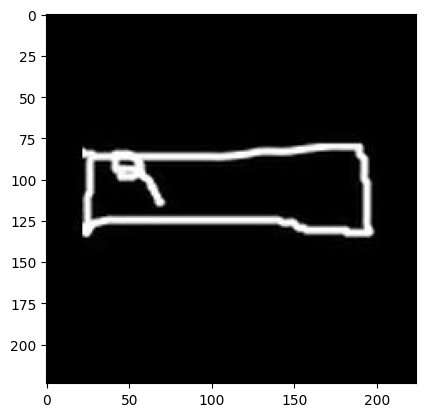

In [53]:
test_data = DataLoader(test_set_path)
test_data.load_data()
#test_data.show_image(300)

In [55]:
class SketchClassificatorModel:
    
    def __init__(self, data, model_version, epochs, batch_size, validation_split, dropout) -> None:
        self._data = data
        self._shape = data.shape
        self.num_classes = len(CATEGORIES_CODES)
        
        self.model = models.Sequential()
        self.version = model_version
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.val_split = validation_split
        self.dropout = dropout

    def build_model(self) -> None:
        activation, final_activation = 'relu', 'softmax'
        kernel_size, pool_size = (6, 6), (4, 4)
        
        self.model.add(layers.Conv2D(32, kernel_size=kernel_size, activation=activation, input_shape=self._shape))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(64, kernel_size=kernel_size, activation=activation))
        self.model.add(layers.MaxPooling2D(pool_size=pool_size))
        self.model.add(layers.Conv2D(128, kernel_size=kernel_size, activation=activation))
        self.model.add(layers.Flatten())
        
        self.model.add(layers.Dense(128, activation=activation))
        self.model.add(layers.Dropout(self.dropout))
        self.model.add(layers.Dense(self.num_classes, activation=final_activation))
        
        self.model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    def train_model(self) -> None:
        self.model.fit(self._data.images, self._data.labels, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.val_split)
    
    def save_model(self) -> None:
        self.model.save(f'models/model_v{self.version}.h5')
        
    def run(self) -> None:
        self.build_model()
        self.train_model()
        self.save_model()

In [57]:
new_model_version='0.4.1(no_valid_set)'
sketch_model = SketchClassificatorModel(data=train_data, model_version=new_model_version, epochs=10, batch_size=32, validation_split=0, dropout=0.05)
sketch_model.run()

Epoch 1/10
458/458 [==============================] - 219s 476ms/step - loss: 1.5422 - accuracy: 0.5283
Epoch 2/10
458/458 [==============================] - 224s 489ms/step - loss: 0.9275 - accuracy: 0.7120
Epoch 3/10
458/458 [==============================] - 315s 687ms/step - loss: 0.6751 - accuracy: 0.7884
Epoch 4/10
458/458 [==============================] - 296s 646ms/step - loss: 0.4912 - accuracy: 0.8431
Epoch 5/10
458/458 [==============================] - 306s 667ms/step - loss: 0.3423 - accuracy: 0.8875
Epoch 6/10
458/458 [==============================] - 302s 660ms/step - loss: 0.2452 - accuracy: 0.9210
Epoch 7/10
458/458 [==============================] - 312s 682ms/step - loss: 0.1672 - accuracy: 0.9458
Epoch 8/10
458/458 [==============================] - 200s 437ms/step - loss: 0.1414 - accuracy: 0.9543
Epoch 9/10
458/458 [==============================] - 199s 435ms/step - loss: 0.1123 - accuracy: 0.9644
Epoch 10/10
458/458 [==============================] - 200s 436m

C:\Users\julia\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
for models in os.listdir('models'):
    model_test = load_model(f'models/{models}')
    print(f'Model version: {models[7:-3]}')
    test_loss, test_accuracy = model_test.evaluate(test_data.images, test_data.labels)

Model version: 0.2
25/25 [==============================] - 3s 117ms/step - loss: 1.2435 - accuracy: 0.7597
Model version: 0.3
25/25 [==============================] - 3s 113ms/step - loss: 1.1196 - accuracy: 0.7117
Model version: 0.4.1(no_valid_set)
25/25 [==============================] - 3s 124ms/step - loss: 1.4528 - accuracy: 0.7714


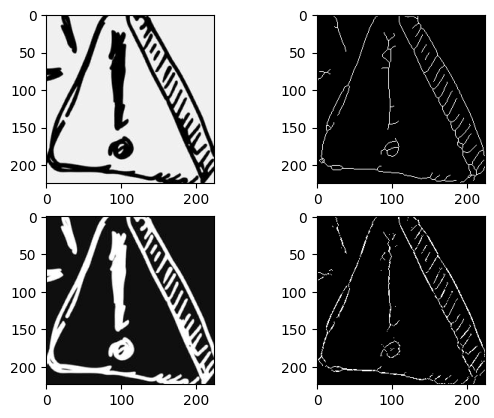

In [48]:
'''def img_skeletonizing(image):
    _, img_ = cv2.threshold(image, 127, 255, 0)
    
    skeleton = np.zeros(img_.shape, np.uint8)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
    
    while True:
        open_img = cv2.morphologyEx(img_, cv2.MORPH_OPEN, element)
        temp = cv2.subtract(img_, open_img)
        eroded = cv2.erode(img_, element)
        skeleton = cv2.bitwise_or(skeleton, temp)
        img_ = eroded.copy()
        if cv2.countNonZero(img_)==0:
            break
    
    return skeleton
        
img_index=1
fig = plt.figure()


#skeleton version Van4o
img_ = cv2.imread(f"data/train/alert/{os.listdir('data/train/alert/')[img_index]}", 0)/255
image_ = morphology.skeletonize(img1.reshape(224, 224) < 0.5)

fig.add_subplot(2, 2, 1) 
plt.imshow(img_, cmap='gray')
fig.add_subplot(2, 2, 2) 
plt.imshow(image_, cmap='gray')


#skeleton version Yulian
img_ = ~cv2.imread(f"data/train/alert/{os.listdir('data/train/alert/')[img_index]}", 0)

fig.add_subplot(2, 2, 3) 
plt.imshow(img_, cmap='gray')
fig.add_subplot(2, 2, 4) 
plt.imshow(img_skeletonizing(img_), cmap='gray')'''